In [2]:
from jupyter_rs_radia import radia_viewer
import numpy as np
import os
import time
import plotly.graph_objects as go

In [3]:
import pymesh
import trimesh
from rsradia import plots

# Simple Cut Block

In [4]:
pm_mesh = pymesh.meshio.load_mesh('shapr3d_export_2021-09-08_13h01m.stl')

In [5]:
t_mesh = trimesh.Trimesh(vertices=pm_mesh.vertices,
                         faces=pm_mesh.faces)

## Visualize Mesh

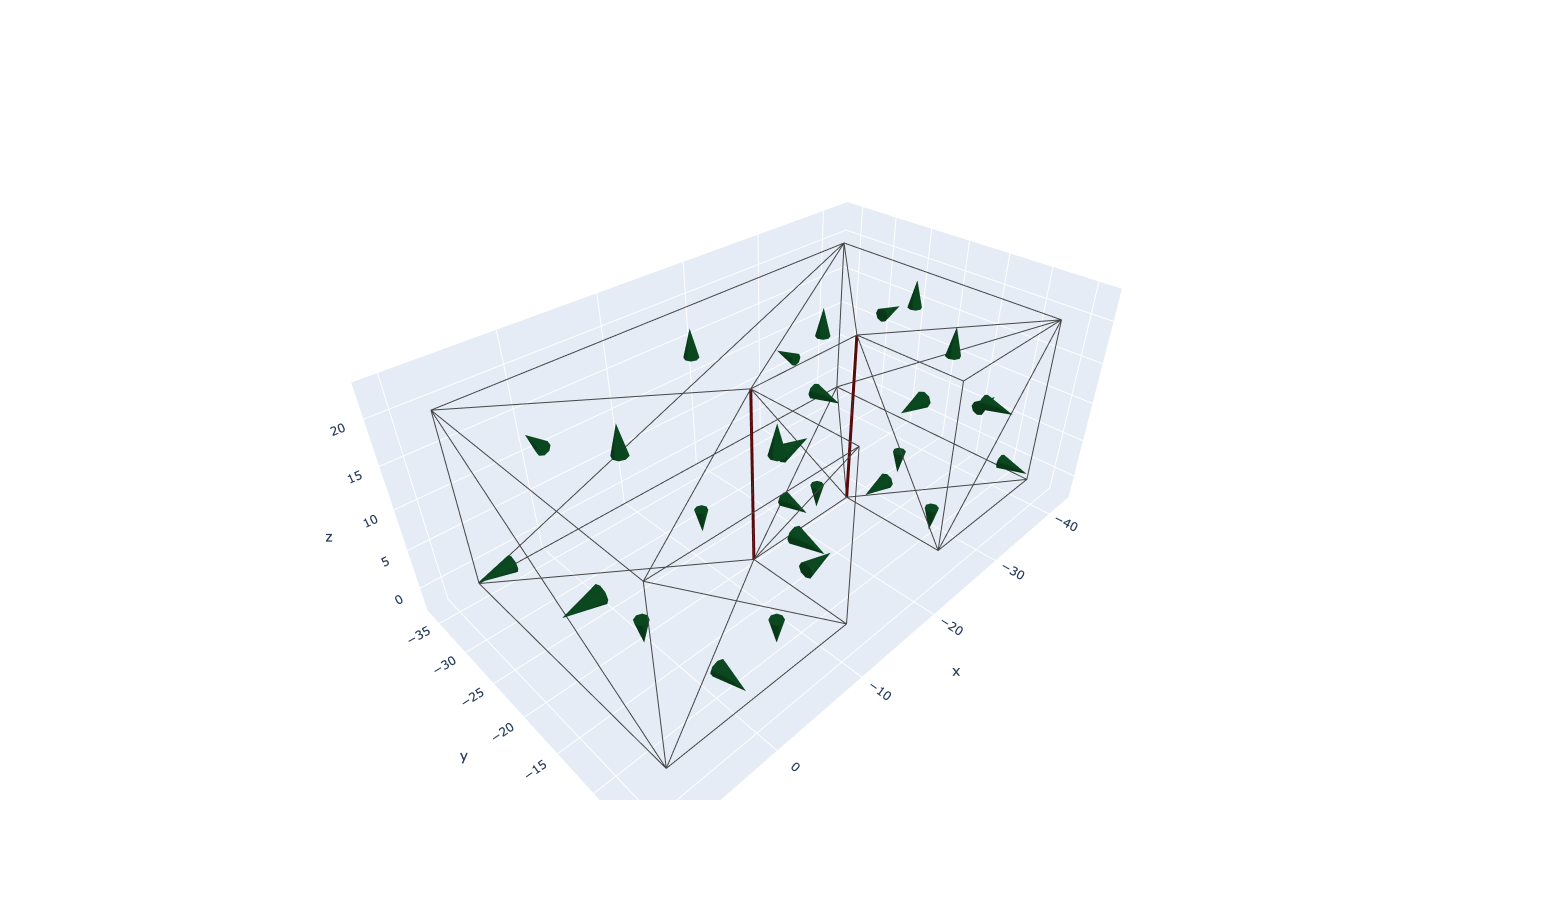

In [16]:
plots.plot_mesh(t_mesh, wireframe=True,
                incenters= 'normal', 
                nonconvex_faces=True)

In [7]:
print("The base mesh is convex:", t_mesh.is_convex)

The base mesh is convex: False


# Generate an Approximate Convex Decomposition
Uses VHACD
- resolution: See fairly significant improvement at 10e6 with no other changes (quite slow though)
- pca: tried 1 with ~1e6 resolution, very bad result
- mode: switching to 1 gives a nonconvex result that can be better obtained with just convex hull calculations
- depth: going to 32 with resolution of 1e6 didn't offer much improvement

## Generate VHACD Decomp or Load Existing from File

In [8]:
DECOMP_DIR = 'dumped_mesh_cut_block'
DECOMP_FILE = 'decomp_mesh_{i}.stl'

In [9]:
if not os.path.isfile(os.path.join(DECOMP_DIR, DECOMP_FILE.format(i=0))):
    s1 = time.time()
    print(f"{DECOMP_FILE} not found. Generating new decomposition.")
    vhacd_options = {'resolution': '10000000',
                     'depth': '32',
                     'planeDownsampling': '4',
                     'convexhullDownsampling': '4',
                     'mode': '0',
                     'maxNumVerticesPerCH': '128',
                     'minVolumePerCH': '0.00005'}
    decomposed_mesh_pieces = trimesh.decomposition.convex_decomposition(t_mesh, **vhacd_options)
    print("Decomposition took", time.time() - s1, 'seconds')
else:
    print(f'Decomposition save exsists: {DECOMP_FILE}')
    decomposed_mesh_pieces = [trimesh.load(os.path.join(DECOMP_DIR, df)) for df in os.listdir(DECOMP_DIR)]

Decomposition save exsists: decomp_mesh_{i}.stl


In [10]:
for mm in decomposed_mesh_pieces:
    print(mm.is_convex)

True
True
True


In [11]:
if not os.path.isfile(os.path.join(DECOMP_DIR, DECOMP_FILE.format(i=0))):
    for i, mm in enumerate(decomposed_mesh_pieces):
        _ = mm.export(os.path.join(DECOMP_DIR, DECOMP_FILE.format(i=i)))
else:
    print("{} exists. Concatentated mesh not saved to file.".format(os.path.join(DECOMP_DIR, DECOMP_FILE.format(i=0))))

dumped_mesh_cut_block/decomp_mesh_0.stl exists. Concatentated mesh not saved to file.


## Visualize Decomposition

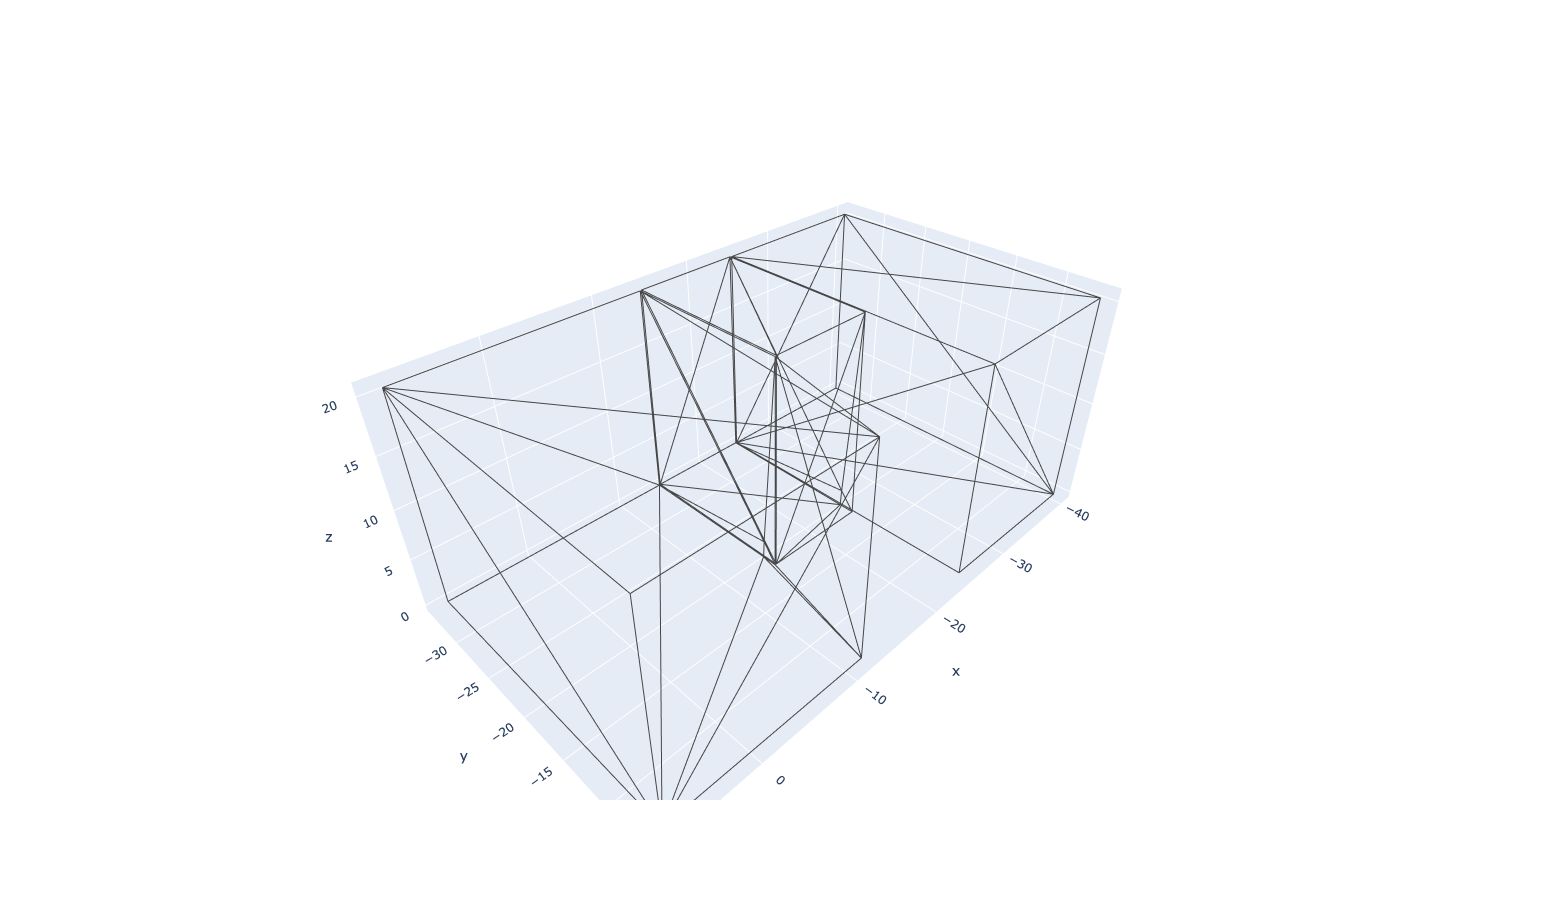

In [12]:
plots.plot_mesh(np.sum(decomposed_mesh_pieces))

# Bring into Radia

In [13]:
import radia

## Import Decomposed Mesh to Radia
First block in this example causes Radia to crash if loading is attempted

In [14]:
# Radia needs indexing to start at 1
# Import individual decomposed meshes one-by-one

radia_object = []
for i, mm in enumerate(decomposed_mesh_pieces[1:]):  # Change starting index to 0 to observe crash
    reindex_faces = mm.faces + 1
    vertices_resize = mm.vertices * 1
    print('Starting mesh', i)
    time.sleep(1)
    new_obj = radia.ObjPolyhdr(vertices_resize.tolist(), reindex_faces.tolist())
    radia_object.append(new_obj)
    print('Finished mesh', i, '\n')


Starting mesh 0
Finished mesh 0 

Starting mesh 1
Finished mesh 1 



## Show result from Radia

In [15]:
magnet = radia.ObjCnt(radia_object)

# define radia viewer
rv = radia_viewer.RadiaViewer()
rv.add_geometry('Magnet', magnet)

# Show radia viewer
rv.display()

RadiaViewer(children=(Viewer(children=(VTK(layout=Layout(margin='auto', min_width='25%', width='50%'), model_d…

# Failing Mesh in Radia
Mesh Piece 0 will cause Radia to crash if you attempt to laod it

## Mesh Check - All pieces
- Watertight
- Convex

In [16]:
a_mesh_failed = False
for i, mm in enumerate(decomposed_mesh_pieces):
    if not mm.is_watertight:
        print(i, "is not watertight")
        a_mesh_failed = True
    if not mm.is_convex:
        print(i, "is not convex")
        a_mesh_failed = True
if not a_mesh_failed:
    print("All meshes passed")


All meshes passed


## Examine Piece that Radia Will not Load

In [17]:
failing_mesh = decomposed_mesh_pieces[0]

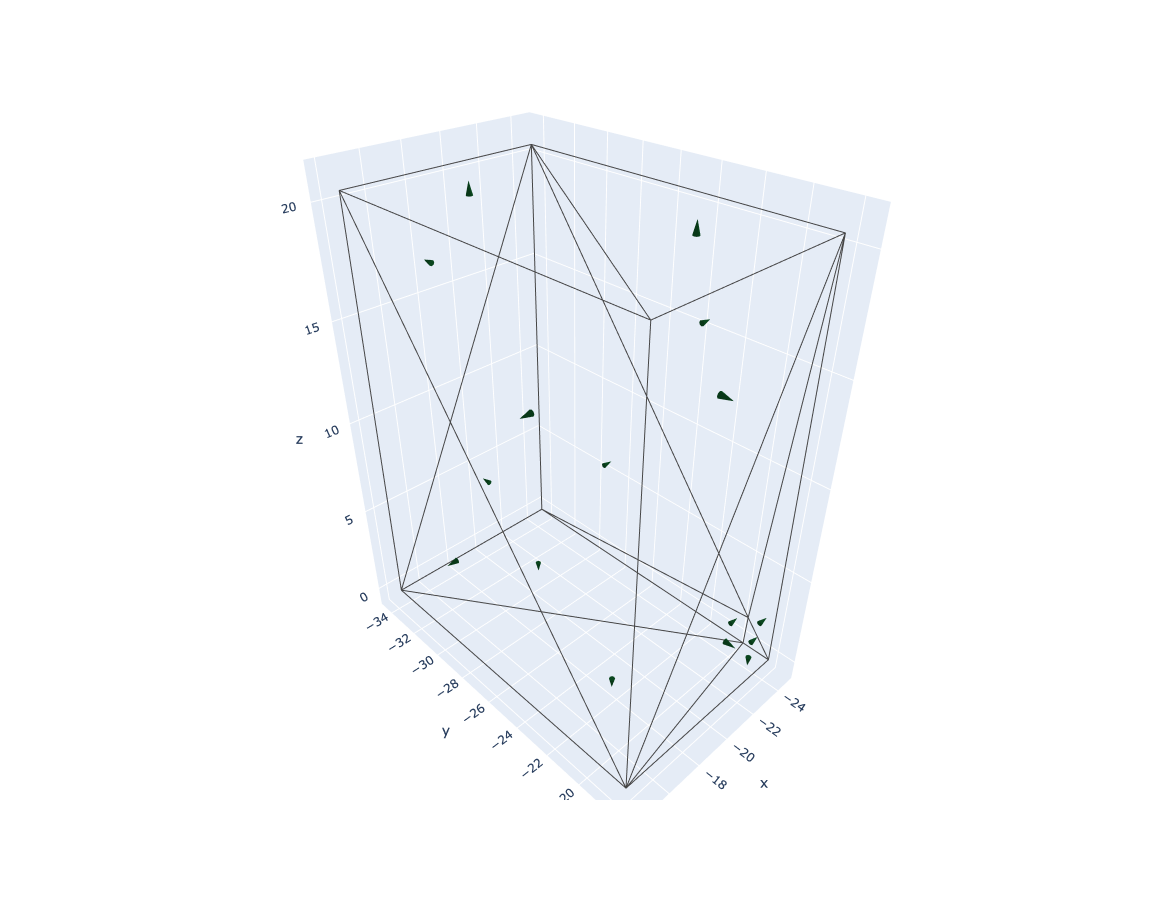

In [18]:
plots.plot_mesh(failing_mesh, incenters='normal')

# Convex Restriction Source?

```
"Radia::Error106::::Non-convex polyhedron encountered. Non-convex polyhedrons can not be used as basic 3D objects in Radia. Try to represent the volume by a group of several convex polyhedrons.\0",
```

# Extruded base - Get just vertices and faces in z=0 plane

In [22]:
import matplotlib.pyplot as plt

In [23]:
base_vertices = np.where(t_mesh.vertices[:, 2] < 1.0)[0]

In [24]:
base_faces = np.all(np.isin(t_mesh.faces, base_vertices), axis=1)

## Re-map Connections

In [25]:
# faces are index references to vertices which are being re-mapped
mapping = {v: i for i, v in enumerate(base_vertices)}

remapped_base_faces = np.empty_like(t_mesh.faces[base_faces])
for i in range(remapped_base_faces.shape[0]):
    for j in range(remapped_base_faces.shape[1]):
        remapped_base_faces[i, j] = mapping[t_mesh.faces[base_faces][i, j]]

In [26]:
base_mesh = trimesh.Trimesh(vertices=t_mesh.vertices[base_vertices], faces=remapped_base_faces)

## Check Result

In [27]:
def plot_plane_mesh(mesh):
    plt.figure()
    for face in mesh.faces:
        plt.plot(np.tile(mesh.vertices[face, 0],2)[:4], 
                 np.tile(mesh.vertices[face, 1],2)[:4], c='C0')
    plt.scatter(base_mesh.vertices[:, 0],
                base_mesh.vertices[:, 1], c='C1')
    plt.show()

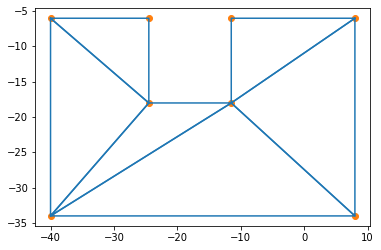

In [28]:
plot_plane_mesh(base_mesh)

### Generate Extrusion

In [29]:
sorted_vertices = [2, 0, 1, 5, 4, 6, 7, 3]

In [30]:
center = 0.
length = 10.

coordinates = list(list(pair) for pair in base_mesh.vertices[:, [0, 1]][sorted_vertices])
pole_sub = [[1, 1] for _ in range(len(coordinates))]

pole =  radia.ObjMltExtTri(center, length, coordinates, pole_sub)

In [31]:
extrusion_magnet = radia.ObjCnt([pole, ])

In [32]:
rv = radia_viewer.RadiaViewer()
rv.add_geometry('Test', extrusion_magnet)

In [33]:
rv.display()

RadiaViewer(children=(Viewer(children=(VTK(layout=Layout(margin='auto', min_width='25%', width='50%'), model_d…

# Exact 3D Decomposition

- Best implementation so far (very general with few restriction, conceptually straightforward):

Chazelle, Bernard. "Convex partitions of polyhedra: a lower bound and worst-case optimal algorithm." SIAM Journal on Computing 13.3 (1984): 488-507.

Works analgous to 2D approac. Greatly simplified:
- Find a notch (reflex vertex/edge)
- Slice from the notch to form two new polyhedra
- Repeat until only convex polyhedra remain


<img src='decomp.png' width="400" height="400">

#### - Original implementation not designed for triangular meshes. Would have to re-mesh polygons formed from cut plane intersection with existing surfaces.

# Sliced mesh

In [ ]:
# Try slicing extruded mesh just to see what Radia gives back

In [43]:
section_l = trimesh.intersections.slice_mesh_plane(t_mesh, plane_normal=(1, 0, 0), plane_origin=(0, 0, 0))
section_r = trimesh.intersections.slice_mesh_plane(t_mesh, plane_normal=(-1, 0, 0), plane_origin=(0, 0, 0))

section_a = trimesh.intersections.slice_mesh_plane(t_mesh, plane_normal=(1, 1, 0), plane_origin=(0, 0, 0))

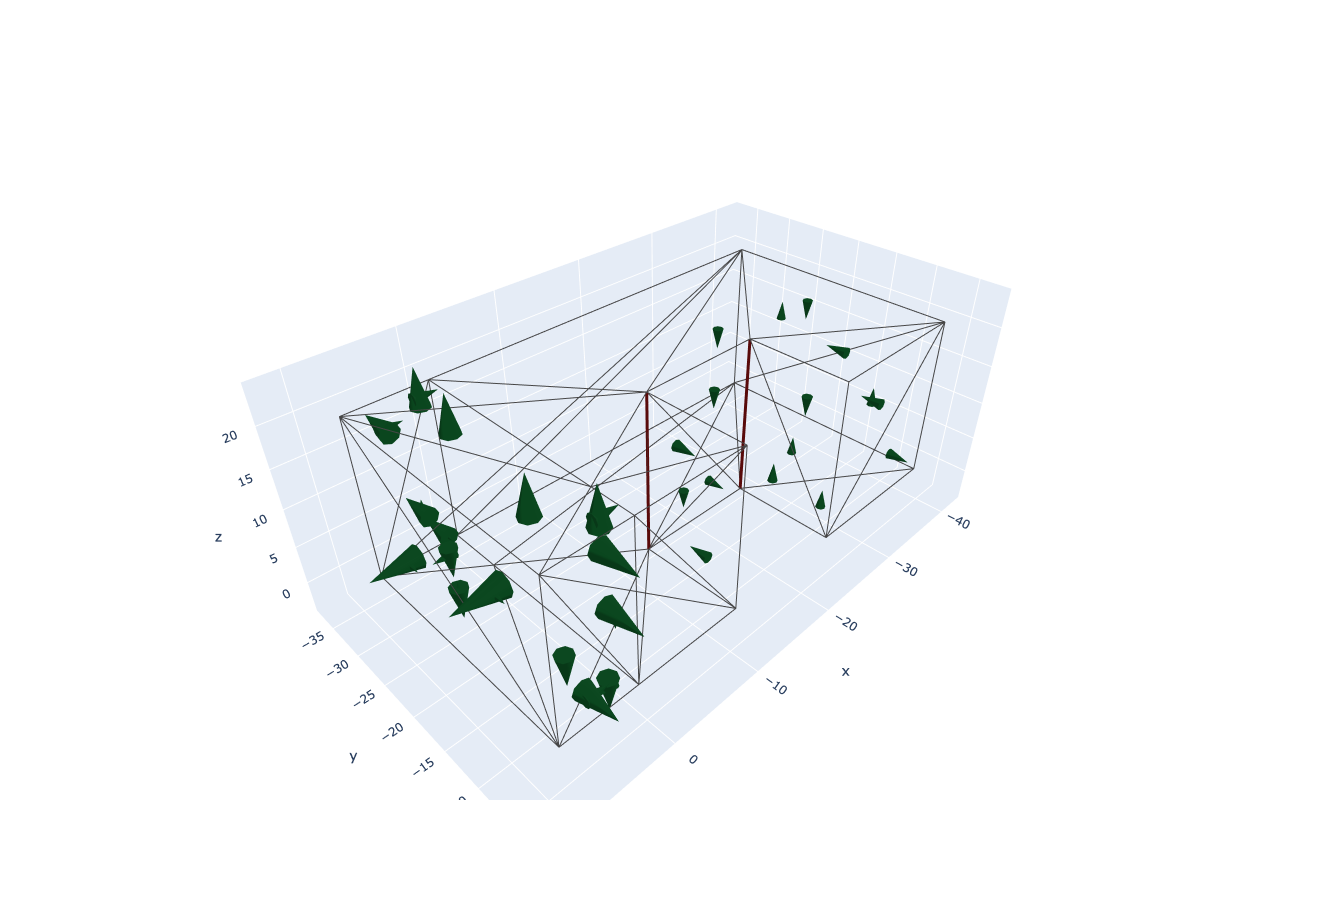

In [44]:
plots.plot_mesh([section_l, section_r], wireframe=True,
                incenters= 'normal', 
                nonconvex_faces=True)

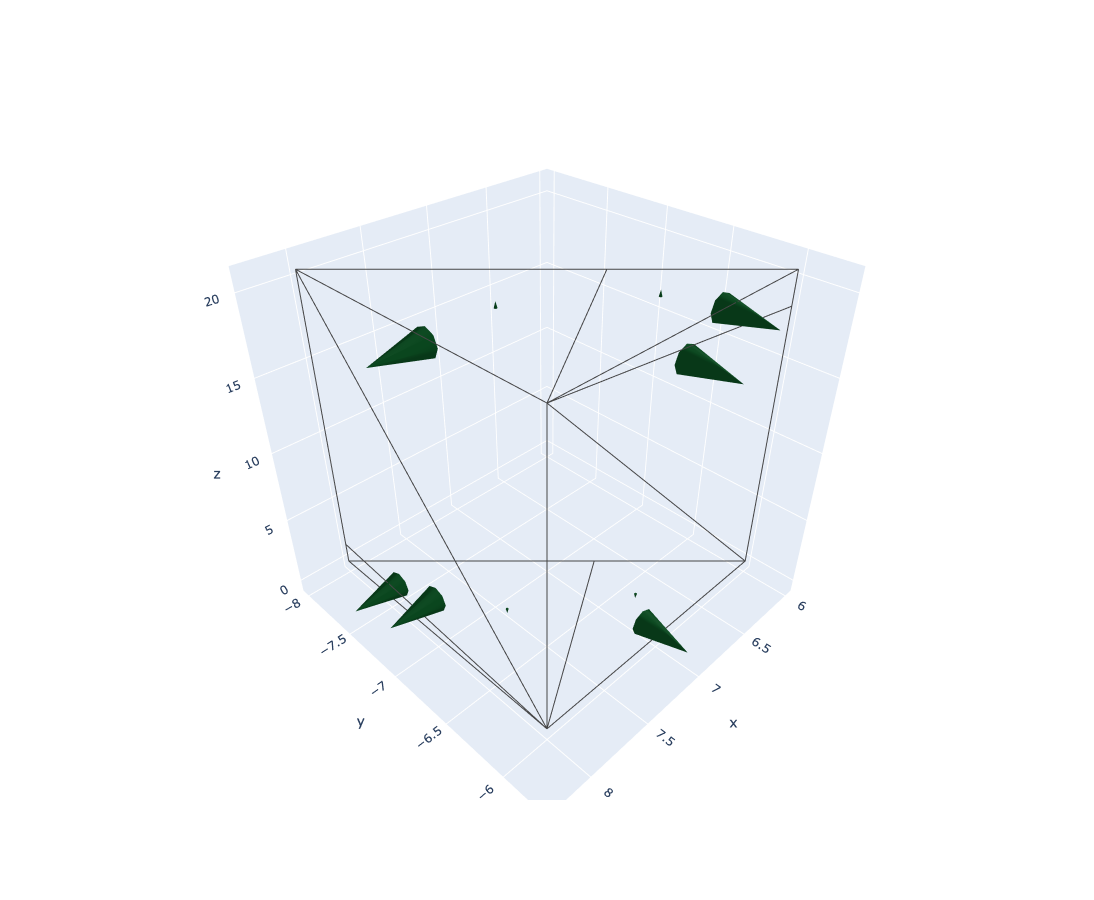

In [45]:
plots.plot_mesh([section_a, ], wireframe=True,
                incenters= 'normal', 
                nonconvex_faces=True)